In [1]:
from pathlib import Path
USE_COLAB: bool = True
dataset_base_path = Path("/content/drive/My Drive/ECE 792 - Advance Topics in Machine Learning/Datasets")
if USE_COLAB:
  from google.colab import drive
  
  # Mount the drive to access google shared docs
  drive.mount('/content/drive/', force_remount=True)

  if dataset_base_path.exists():
    print("Folder exists")
  else:
    print("DOESN'T EXIST. Add desired folder as a shortcut in your 'My Drive'")

Mounted at /content/drive/
Folder exists


In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from typing import Tuple, Optional, List

import argparse
import os
from tqdm import tqdm
import time
import copy
import math
from zipfile import ZipFile

from PIL import Image
from typing import Dict, List, Union

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# PyTorch's versions:
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("NumPy Version: ",np.__version__)
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

PyTorch Version:  1.13.1+cu116
Torchvision Version:  0.14.1+cu116
NumPy Version:  1.22.4
Fri Mar 24 17:22:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+

In [3]:
class CelebrityData(torch.utils.data.Dataset):

  def __init__(
    self,
    base_path: Path,
    transform = None,
    seed = None,
    gans_to_skip: Optional[List[str]] = None,
    n_fake_imgs_to_extract: int = 40000,
    *,
    unzip_real_imgs: bool = True,
    ):
    '''
    Folder structure of base_path should be
    base_path -> RealFaces/FakeFaces
    RealFaces -> .zip
    FakeFaces -> GANType -> .zip (e.g., FakeFaces -> PGGAN -> .zip)
    '''
    super().__init__()
    self.rng = np.random.default_rng(seed)
    self.unzip_real_imgs = unzip_real_imgs

    self.fake_images_path = Path(base_path) / "FakeFaces"
    self.fake_image_gan_names = os.listdir(str(self.fake_images_path))
    if gans_to_skip is not None:
      print(f"Not unzipping '{gans_to_skip}'")
      self.fake_image_gan_names = list(filter(lambda x: x not in gans_to_skip, self.fake_image_gan_names))
    self.fake_images: Dict[str, List[Union[str, Path]]] = {}
    for fake_image_gan_name in self.fake_image_gan_names:
      print(f"Extracting imagery for '{fake_image_gan_name}'")
      fake_image_gan_path = self.fake_images_path / fake_image_gan_name
      zip_file = sorted(fake_image_gan_path.glob("*.zip"))
      if len(zip_file) == 1:
        zip_file = zip_file[0]
        with ZipFile(str(zip_file), 'r') as zipObj:
          zipObj.extractall()
        self.fake_images.update({fake_image_gan_name: zipObj.namelist()[:n_fake_imgs_to_extract]})
      else:
        fake_image_paths = sorted(fake_image_gan_path.glob("*.jpg"))
        self.fake_images.update({fake_image_gan_name: fake_image_paths[:n_fake_imgs_to_extract]})

    self.n_fake_gans = len(list(self.fake_images.keys()))

    if unzip_real_imgs:
      self.real_images_path = Path(base_path) / "RealFaces"
      print("Extracting RealFaces imagery")
      real_images_zip_files = sorted(self.real_images_path.glob("*.zip"))
      if len(real_images_zip_files) != 1:
        raise RuntimeError(f"Got more than or less than 1 zip file in '{self.real_images_path}'. Got '{len(real_images_zip_files)}'")
      self.real_images_zip_file = real_images_zip_files[0]
      # Create a ZipFile Object and load sample.zip in it
      with ZipFile(str(self.real_images_zip_file), 'r') as zipObj:
        # Extract all the contents of zip file in current directory
        zipObj.extractall()
      self.real_images = zipObj.namelist()[1:self.len_of_fake_images+1]
    else:
      self.real_imgs = []

    self.transform = transform

    # according to Deep Fake Image Detection Based on Pairwise Learning, we need to make combinations for all
    # real images with all fake images
    fake_img_list = []
    for fake_imgs in self.fake_images.values():
      fake_img_list.extend(fake_imgs)
    self.fake_img_list = fake_img_list

  def fake_image_rand_selection(self, index) -> str:
    rand_selection = self.rng.uniform(low=-0.499, high=len(self.fake_images) - 0.501)
    gan_selection = self.fake_image_gan_names[int(np.round(rand_selection))]
    
    return self.fake_images.get(gan_selection)[index // len(self.fake_images)]

  @property
  def len_of_fake_images(self) -> int:
    total_len = 0
    for val in self.fake_images.values():
      total_len += len(val)

    return total_len

  def len_of_real_and_fake(self):
    return len(self.real_images) + self.len_of_fake_images

In [4]:
import re
def get_latest_model(base_path, suffix: str = ".pt") -> Path:
  epoch_num = []
  all_files = sorted(Path(base_path).glob("*.pth"))
  for file_ in all_files:
    idx_num = re.search("--", str(file_)).span()
    idx_pt = re.search(suffix, str(file_)).span()
    model_num = str(file_)[idx_num[-1]:idx_pt[0]]
    try:
      epoch_num.append(int(model_num))
    except ValueError:
      idx_num = re.search("--", str(model_num)).span()
      epoch_num.append(int(model_num[idx_num[-1]:]))

  idx = epoch_num.index(np.max(epoch_num))
  return all_files[idx]

Two-step learning policy as employed by 'Deep Fake Image Detection Based on Pairwise Learning'. Therefore, we first train the CFFN network with the contrastive loss. After the CFFN network is learned to minimize the contrastive loss, we then train the classification network using the outputs from the CFFN network, as this better feature representation output will allow the classification network to better classify the images as fake or real. The classification network is trained using the binary cross-entropy loss of predicting whether the image is real or fake [p.6. section 2.4]

In [5]:
from sklearn.preprocessing import OneHotEncoder

def circular_index(idx: int, upper_bound: int) -> int:
  if idx < upper_bound:
    return idx
  return idx - (upper_bound * (idx // upper_bound))

class CelebrityDataClassificationNetwork(CelebrityData):
  def __init__(
      self,
      base_path: Path,
      transform = None,
      seed = None,
      gans_to_skip: Optional[List[str]] = None,
      unzip_real_imgs: bool = True,
  ):
    super().__init__(
        base_path=base_path,
        transform=transform,
        seed=seed,
        gans_to_skip=gans_to_skip,
        unzip_real_imgs=unzip_real_imgs,
    )
    self.to_tensor = transforms.ToTensor()
    self.enc = OneHotEncoder()
    self.enc.fit([[0], [1]])

  def __getitem__(self, index):
    img_path, label, gan_selection = self.choose_real_or_fake_image(index)

    img = Image.open(img_path).convert('RGB')
    if self.transform is not None:
      img = self.transform(img)
    else:
      img = self.to_tensor(img)

    return img, label, gan_selection

  def choose_real_or_fake_image(self, index) -> Tuple[str, np.ndarray, str]:
    if self.rng.standard_normal() > 0:
      img = self.real_images[circular_index(index // 2, len(self.real_images))]  # divide by 2 b/c we define __len__ as all real & fake images
      gan_selection = "real"
      label = [1]
    else:
      img, gan_selection = self.fake_image_rand_selection(index)
      label = [0]

    label = np.squeeze(self.enc.transform(np.column_stack(label).reshape(-1, 1)).toarray())
    return img, label.astype(np.float32), gan_selection

  def fake_image_rand_selection(self, index) -> str:
    rand_selection = self.rng.uniform(low=-0.499, high=self.n_fake_gans - 0.501)
    gan_selection = self.fake_image_gan_names[int(np.round(rand_selection))]

    return self.fake_images[gan_selection][index // (self.n_fake_gans * 2)], gan_selection  # mult den by 2 b/c of definition of __len__ being all real & fake images

  def names_of_gans(self) -> List[str]:
    return list(self.fake_images.keys())

  def __len__(self):
    return len(self.real_images) + self.len_of_fake_images

**1. Common Fake Feature Network**

Network structure includes a pairwise learning approach. "A fake face image detector based on the novel CFFN, consisting of an improved DenseNet backbone network and Siamese network architecture...The cross-layer features are investigated by the proposed CFFN, which can be used to improve the performance."

The fake and real images are paired together and the pairwise information is used to construct the contrastive loss to learn the discriminative common fake feature (CFF) by the CFFN. The paper states that 2 million pairwise samples are used for training.

"One way to learn both the CFFs and classifier is the join learning strategy incorporating the contrastive loss and cross-entropy loss into the total energy function. In another way, the CFFN is first trained by the proposed contrastive loss and follows by training the classifier based on cross-entropy loss. When the first strategy is applied, it is difficult to observe the impact of both contrastive and cross-entropy loss functions on the performance of the fake image detection tasks. Therefore, we adopt the second strategy to ensure the best performance of the proposed method."

In [6]:
# We will be working with GPU:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device : ' , device)

# Number of GPUs available. 
num_GPU = torch.cuda.device_count()
print('Number of GPU : ', num_GPU)

model_output_path = Path("/content/drive/MyDrive/ECE 792 - Advance Topics in Machine Learning/Code/DeepFakeImageDetection/CFFN/model")

config = { 'batch_size'             : 88,
           'image_size'             : 64,
           'n_channel'              : 3,
           'n_epochs'               : 15,
           'lr'                     : 1e-3,
           'growth_rate'            : 24,
           'transition_layer_theta' : 0.5,
           'device'                 : device,
           'm_th'                   : 0.5,
           'n_combinations'         : 2e6,
           'seed'                   : 999,
           'model_output_path'      : model_output_path,
           'chkp_freq'              : 1,  # number of epochs to save model out
           'n_workers'              : 4,
          #  'gans_to_skip'           : ["CDCGAN", "LSGAN", "WGAN-GP"],
}

celebrity_data = None

Device :  cuda
Number of GPU :  1


In [7]:
if celebrity_data is None:
  celebrity_data = CelebrityDataClassificationNetwork(
    base_path=dataset_base_path,
    transform=transforms.Compose(
      [
        transforms.Resize(int(config["image_size"] * 1.1)),
        transforms.CenterCrop(config["image_size"]),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
      ]
    ),
    seed=config["seed"],
    gans_to_skip=config.get("gans_to_skip"),
  )

dataloader = torch.utils.data.DataLoader(
  dataset=celebrity_data,
  shuffle=True,
  batch_size=config["batch_size"],
  num_workers=config["n_workers"],
  drop_last=True,  # drop last batch that may not be the same size as the expected batch for the network
  pin_memory=True,
)

Extracting imagery for 'WGAN-CP'
Extracting imagery for 'PGGAN'
Extracting imagery for 'DCGAN'
Extracting imagery for 'LSGAN'
Extracting imagery for 'CDCGAN'
Extracting imagery for 'WGAN-GP'
Extracting RealFaces imagery


In [8]:
from typing import Callable, Tuple
from tqdm import tqdm

class DenseBlock2(nn.Module):
  conv0_0_out = None
  conv0_1_out = None
  batch_norm0_out = None
  concat0_out = None
  activation0_out = None
  conv1_0_out = None
  conv1_1_out = None
  batch_norm1_out = None
  concat1_out = None
  activation1_out = None
  trans_layer_out = None
  trans_layer_out_indices = None

  def __init__(
    self,
    in_channels: int,
    out_channels: int,
    growth_rate: int,
    transition_layer_theta: float,
    device: torch.device = None,
  ):
    super().__init__()
    if device is None:
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.conv0_0 = nn.Conv2d(
      in_channels=in_channels,
      out_channels=in_channels * 2,
      kernel_size=(1, 1),
      padding=0,
      stride=(1, 1),
      device=device,
    )
    self.conv0_1 = nn.Conv2d(
      in_channels=in_channels * 2,
      out_channels=growth_rate,
      kernel_size=(3, 3),
      padding=1,
      stride=(1, 1),
      device=device,
    )
    self.batch_norm0 = nn.BatchNorm2d(in_channels + growth_rate, device=device)

    self.conv1_0 = nn.Conv2d(
      in_channels=in_channels + growth_rate,
      out_channels=(in_channels + growth_rate) * 2,
      kernel_size=(1, 1),
      padding=0,
      stride=(1, 1),
      device=device,
    )
    self.conv1_1 = nn.Conv2d(
      in_channels=(in_channels + growth_rate) * 2,
      out_channels=growth_rate,
      kernel_size=(3, 3),
      padding=1,
      stride=(1, 1),
      device=device,
    )
    self.batch_norm1 = nn.BatchNorm2d(in_channels + (2 * growth_rate), device=device)

    trans_kernel_size = int(1/transition_layer_theta)
    self.trans_layer = nn.MaxPool3d(kernel_size=(trans_kernel_size, 1, 1), return_indices=True)
    self.activation_func = nn.ReLU()

  def reconstruction_entries(self, index: int, trans_layer_out: Optional[torch.Tensor] = None) -> dict:
    if not isinstance(index, int):
      if len(index) > 1:
        raise RuntimeError(f"got multiple indices for DenseBlock4 reconstruction. Only one index at a time is supported currently.")
    
    if trans_layer_out is None:
      trans_layer_out = self.trans_layer_out[index].unsqueeze(0)
    
    maxunpool = nn.MaxUnpool3d(kernel_size=self.trans_layer.kernel_size)
    maxpool_idx = self.trans_layer_out_indices[index].unsqueeze(0)
    trans_layer_unpool = maxunpool(trans_layer_out, maxpool_idx).squeeze()
    trans_layer_act = self.activation_func(trans_layer_unpool.unsqueeze(0))

    weights = [
      self.conv1_1.weight, self.conv1_0.weight, self.conv0_1.weight, self.conv0_0.weight,
    ]
    deconv_shape_determinations = [
        (1, 3, 1), (0, 1, 1), (1, 3, 1), (0, 1, 1),
    ]
    deconv_shape_upsample_factors = [1, 1, 1, 1]
    reconstruction_inputs = [
        trans_layer_act[:, :self.conv1_1_out.shape[1]],
        self.conv1_0_out[index],
        self.activation0_out[index, :self.conv0_1_out.shape[1]],
        self.conv0_0_out[index],
    ]
    activation_layers = [
      self.activation_func,
      None,
      self.activation_func,
      None,
    ]
    indexing_for_unconcatenating = [
        None,
        self.conv0_1_out.shape[1],
        None,
        None,
    ]

    return {
      "weights": weights,
      "deconv_shape_determinations": deconv_shape_determinations,
      "deconv_shape_upsample_factors": deconv_shape_upsample_factors,
      "reconstruction_inputs": reconstruction_inputs,
      "activation_layers": activation_layers,
      "indexing_for_unconcatenating": indexing_for_unconcatenating,
    }

  def forward(self, x):
    self.conv0_0_out = self.conv0_0(x)
    self.conv0_1_out = self.conv0_1(self.conv0_0_out)
    self.concat0_out = torch.concat((self.conv0_1_out, x), dim=1)
    self.batch_norm0_out = self.batch_norm0(self.concat0_out)
    self.activation0_out = self.activation_func(self.batch_norm0_out)

    self.conv1_0_out = self.conv1_0(self.activation0_out)
    self.conv1_1_out = self.conv1_1(self.conv1_0_out)
    self.concat1_out = torch.concat((self.conv1_1_out, self.activation0_out), dim=1)
    self.batch_norm1_out = self.batch_norm1(self.concat1_out)
    self.activation1_out = self.activation_func(self.batch_norm1_out)

    self.trans_layer_out, self.trans_layer_out_indices = self.trans_layer(self.activation1_out)

    return self.trans_layer_out

class DenseBlock3(nn.Module):
  conv0_0_out = None
  conv0_1_out = None
  batch_norm0_out = None
  concat0_out = None
  activation0_out = None
  conv1_0_out = None
  conv1_1_out = None
  batch_norm1_out = None
  concat1_out = None
  activation1_out = None
  conv2_0_out = None
  conv2_1_out = None
  batch_norm2_out = None
  concat2_out = None
  activation2_out = None
  trans_layer_out = None
  trans_layer_out_indices = None

  def __init__(
    self,
    in_channels: int,
    out_channels: int,
    growth_rate: int,
    transition_layer_theta: float,
    device: torch.device = None,
  ):
    super().__init__()
    if device is None:
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.conv0_0 = nn.Conv2d(
      in_channels=in_channels,
      out_channels=in_channels * 2,
      kernel_size=(1, 1),
      padding=0,
      stride=(1, 1),
      device=device,
    )
    self.conv0_1 = nn.Conv2d(
      in_channels=in_channels * 2,
      out_channels=growth_rate,
      kernel_size=(3, 3),
      padding=1,
      stride=(1, 1),
      device=device,
    )
    self.batch_norm0 = nn.BatchNorm2d(in_channels + growth_rate, device=device)

    self.conv1_0 = nn.Conv2d(
      in_channels=in_channels + growth_rate,
      out_channels=(in_channels + growth_rate) * 2,
      kernel_size=(1, 1),
      padding=0,
      stride=(1, 1),
      device=device,
    )
    self.conv1_1 = nn.Conv2d(
      in_channels=(in_channels + growth_rate) * 2,
      out_channels=growth_rate,
      kernel_size=(3, 3),
      padding=1,
      stride=(1, 1),
      device=device,
    )
    self.batch_norm1 = nn.BatchNorm2d(in_channels + (2 * growth_rate), device=device)

    self.conv2_0 = nn.Conv2d(
      in_channels=in_channels + (2 * growth_rate),
      out_channels=(in_channels + (2 * growth_rate)) * 2,
      kernel_size=(1, 1),
      padding=0,
      stride=(1, 1),
      device=device,
    )
    self.conv2_1 = nn.Conv2d(
      in_channels=(in_channels + (2 * growth_rate)) * 2,
      out_channels=growth_rate,
      kernel_size=(3, 3),
      padding=1,
      stride=(1, 1),
      device=device,
    )
    self.batch_norm2 = nn.BatchNorm2d((in_channels + (3 * growth_rate)), device=device)

    trans_kernel_size = int(1/transition_layer_theta)
    self.trans_layer = nn.MaxPool3d(kernel_size=(trans_kernel_size, 1, 1), return_indices=True)
    self.activation_func = nn.ReLU()

  def reconstruction_entries(self, index: int, trans_layer_out: Optional[torch.Tensor] = None) -> dict:
    if not isinstance(index, int):
      if len(index) > 1:
        raise RuntimeError(f"got multiple indices for DenseBlock4 reconstruction. Only one index at a time is supported currently.")
    
    if trans_layer_out is None:
      trans_layer_out = self.trans_layer_out[index].unsqueeze(0)

    maxunpool = nn.MaxUnpool3d(kernel_size=self.trans_layer.kernel_size)
    maxpool_idx = self.trans_layer_out_indices[index].unsqueeze(0)
    trans_layer_unpool = maxunpool(trans_layer_out, maxpool_idx).squeeze()
    trans_layer_act = self.activation_func(trans_layer_unpool.unsqueeze(0))

    weights = [
      self.conv2_1.weight, self.conv2_0.weight, self.conv1_1.weight,
      self.conv1_0.weight, self.conv0_1.weight, self.conv0_0.weight,
    ]
    deconv_shape_determinations = [
        (1, 3, 1), (0, 1, 1), (1, 3, 1),
        (0, 1, 1), (1, 3, 1), (0, 1, 1),
    ]
    deconv_shape_upsample_factors = [1, 1, 1, 1, 1, 1]
    reconstruction_inputs = [
        trans_layer_act[:, :self.conv2_1_out.shape[1]],
        self.conv2_0_out[index],
        self.activation1_out[index, :self.conv1_1_out.shape[1]],
        self.conv1_0_out[index],
        self.activation0_out[index, :self.conv0_1_out.shape[1]],
        self.conv0_0_out[index],
    ]
    activation_layers = [
        self.activation_func,
        None,
        self.activation_func,
        None,
        self.activation_func,
        None,
    ]
    indexing_for_unconcatenating = [
        None,
        self.conv1_1_out.shape[1],
        None,
        self.conv0_1_out.shape[1],
        None,
        None,
    ]

    return {
      "weights": weights,
      "deconv_shape_determinations": deconv_shape_determinations,
      "deconv_shape_upsample_factors": deconv_shape_upsample_factors,
      "reconstruction_inputs": reconstruction_inputs,
      "activation_layers": activation_layers,
      "indexing_for_unconcatenating": indexing_for_unconcatenating,
    }

  def forward(self, x):
    self.conv0_0_out = self.conv0_0(x)
    self.conv0_1_out = self.conv0_1(self.conv0_0_out)
    self.concat0_out = torch.concat((self.conv0_1_out, x), dim=1)
    self.batch_norm0_out = self.batch_norm0(self.concat0_out)
    self.activation0_out = self.activation_func(self.batch_norm0_out)

    self.conv1_0_out = self.conv1_0(self.activation0_out)
    self.conv1_1_out = self.conv1_1(self.conv1_0_out)
    self.concat1_out = torch.concat((self.conv1_1_out, self.activation0_out), dim=1)
    self.batch_norm1_out = self.batch_norm1(self.concat1_out)
    self.activation1_out = self.activation_func(self.batch_norm1_out)

    self.conv2_0_out = self.conv2_0(self.activation1_out)
    self.conv2_1_out = self.conv2_1(self.conv2_0_out)
    self.concat2_out = torch.concat((self.conv2_1_out, self.activation1_out), dim=1)
    self.batch_norm2_out = self.batch_norm2(self.concat2_out)
    self.activation2_out = self.activation_func(self.batch_norm2_out)

    self.trans_layer_out, self.trans_layer_out_indices = self.trans_layer(self.activation2_out)

    return self.trans_layer_out

class DenseBlock4(nn.Module):
  conv0_0_out = None
  conv0_1_out = None
  batch_norm0_out = None
  concat0_out = None
  activation0_out = None
  conv1_0_out = None
  conv1_1_out = None
  batch_norm1_out = None
  concat1_out = None
  activation1_out = None
  conv2_0_out = None
  conv2_1_out = None
  batch_norm2_out = None
  concat2_out = None
  activation2_out = None
  conv3_0_out = None
  conv3_1_out = None
  batch_norm3_out = None
  concat3_out = None
  activation3_out = None
  trans_layer_out = None
  trans_layer_out_indices = None

  def __init__(
    self,
    in_channels: int,
    out_channels: int,
    growth_rate: int,
    transition_layer_theta: float,
    device: torch.device = None,
  ):
    super().__init__()
    if device is None:
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.conv0_0 = nn.Conv2d(
      in_channels=in_channels,
      out_channels=in_channels * 2,
      kernel_size=(1, 1),
      padding=0,
      stride=(1, 1),
      device=device,
    )
    self.conv0_1 = nn.Conv2d(
      in_channels=in_channels * 2,
      out_channels=growth_rate,
      kernel_size=(3, 3),
      padding=1,
      stride=(1, 1),
      device=device,
    )
    self.batch_norm0 = nn.BatchNorm2d(in_channels + growth_rate, device=device)

    self.conv1_0 = nn.Conv2d(
      in_channels=in_channels + growth_rate,
      out_channels=(in_channels + growth_rate) * 2,
      kernel_size=(1, 1),
      padding=0,
      stride=(1, 1),
      device=device,
    )
    self.conv1_1 = nn.Conv2d(
      in_channels=(in_channels + growth_rate) * 2,
      out_channels=growth_rate,
      kernel_size=(3, 3),
      padding=1,
      stride=(1, 1),
      device=device,
    )
    self.batch_norm1 = nn.BatchNorm2d(in_channels + (2 * growth_rate), device=device)

    self.conv2_0 = nn.Conv2d(
      in_channels=in_channels + (2 * growth_rate),
      out_channels=(in_channels + (2 * growth_rate)) * 2,
      kernel_size=(1, 1),
      padding=0,
      stride=(1, 1),
      device=device,
    )
    self.conv2_1 = nn.Conv2d(
      in_channels=(in_channels + (2 * growth_rate)) * 2,
      out_channels=growth_rate,
      kernel_size=(3, 3),
      padding=1,
      stride=(1, 1),
      device=device,
    )
    self.batch_norm2 = nn.BatchNorm2d((in_channels + (3 * growth_rate)), device=device)

    self.conv3_0 = nn.Conv2d(
      in_channels=in_channels + (3 * growth_rate),
      out_channels=(in_channels + (3 * growth_rate)) * 2,
      kernel_size=(1, 1),
      padding=0,
      stride=(1, 1),
      device=device,
    )
    self.conv3_1 = nn.Conv2d(
      in_channels=(in_channels + (3 * growth_rate)) * 2,
      out_channels=growth_rate,
      kernel_size=(3, 3),
      padding=1,
      stride=(1, 1),
      device=device,
    )
    self.batch_norm3 = nn.BatchNorm2d((in_channels + (4 * growth_rate)), device=device)

    trans_kernel_size = int(1/transition_layer_theta)
    self.trans_layer = nn.MaxPool3d(kernel_size=(trans_kernel_size, 1, 1), return_indices=True)
    self.activation_func = nn.ReLU()

  def reconstruction_entries(
    self,
    index: int,
    trans_layer_out: Optional[torch.Tensor] = None,
  ) -> dict:
    if not isinstance(index, int):
      if len(index) > 1:
        raise RuntimeError(f"got multiple indices for DenseBlock4 reconstruction. Only one index at a time is supported currently.")
    
    if trans_layer_out is None:
      trans_layer_out = self.trans_layer_out[index].unsqueeze(0)

    maxunpool = nn.MaxUnpool3d(kernel_size=self.trans_layer.kernel_size)
    maxpool_idx = self.trans_layer_out_indices[index].unsqueeze(0)
    trans_layer_unpool = maxunpool(trans_layer_out, maxpool_idx).squeeze()
    trans_layer_act = self.activation_func(trans_layer_unpool.unsqueeze(0))
    
    weights = [
        self.conv3_1.weight, self.conv3_0.weight, self.conv2_1.weight,
        self.conv2_0.weight, self.conv1_1.weight, self.conv1_0.weight,
        self.conv0_1.weight, self.conv0_0.weight,
    ]
    # padding, kernel, stride
    deconv_shape_determinations = [
        (1, 3, 1), (0, 1, 1), (1, 3, 1), (0, 1, 1), (1, 3, 1), (0, 1, 1),
        (1, 3, 1), (0, 1, 1),
    ]
    # stride values last entry in deconv_shape_determinations
    deconv_shape_upsample_factors = [1, 1, 1, 1, 1, 1, 1, 1]
    reconstruction_inputs = [
        trans_layer_act[:, :self.conv3_1_out.shape[1]],
        self.conv3_0_out[index],
        self.activation2_out[index, :self.conv2_1_out.shape[1]],
        self.conv2_0_out[index],
        self.activation1_out[index, :self.conv1_1_out.shape[1]],
        self.conv1_0_out[index],
        self.activation0_out[index, :self.conv0_1_out.shape[1]],
        self.conv0_0_out[index],
    ]
    activation_layers = [
        self.activation_func,
        None,
        self.activation_func,
        None,
        self.activation_func,
        None,
        self.activation_func,
        None,
    ]
    indexing_for_unconcatenating = [
        None,
        self.conv2_1_out.shape[1],
        None,
        self.conv1_1_out.shape[1],
        None,
        self.conv0_1_out.shape[1],
        None,
        None,
    ]

    return {
      "weights": weights,
      "deconv_shape_determinations": deconv_shape_determinations,
      "deconv_shape_upsample_factors": deconv_shape_upsample_factors,
      "reconstruction_inputs": reconstruction_inputs,
      "activation_layers": activation_layers,
      "indexing_for_unconcatenating": indexing_for_unconcatenating,
    }

  def forward(self, x):
    self.conv0_0_out = self.conv0_0(x)
    self.conv0_1_out = self.conv0_1(self.conv0_0_out)
    self.concat0_out = torch.concat((self.conv0_1_out, x), dim=1)
    self.batch_norm0_out = self.batch_norm0(self.concat0_out)
    self.activation0_out = self.activation_func(self.batch_norm0_out)

    self.conv1_0_out = self.conv1_0(self.activation0_out)
    self.conv1_1_out = self.conv1_1(self.conv1_0_out)
    self.concat1_out = torch.concat((self.conv1_1_out, self.activation0_out), dim=1)
    self.batch_norm1_out = self.batch_norm1(self.concat1_out)
    self.activation1_out = self.activation_func(self.batch_norm1_out)

    self.conv2_0_out = self.conv2_0(self.activation1_out)
    self.conv2_1_out = self.conv2_1(self.conv2_0_out)
    self.concat2_out = torch.concat((self.conv2_1_out, self.activation1_out), dim=1)
    self.batch_norm2_out = self.batch_norm2(self.concat2_out)
    self.activation2_out = self.activation_func(self.batch_norm2_out)

    self.conv3_0_out = self.conv3_0(self.activation2_out)
    self.conv3_1_out = self.conv3_1(self.conv3_0_out)
    self.concat3_out = torch.concat((self.conv3_1_out, self.activation2_out), dim=1)
    self.batch_norm3_out = self.batch_norm3(self.concat3_out)
    self.activation3_out = self.activation_func(self.batch_norm3_out)

    self.trans_layer_out, self.trans_layer_out_indices = self.trans_layer(self.activation3_out)

    return self.trans_layer_out

# class DenseBlock(nn.Module):
#   def __init__(
#     self,
#     n_conv: int,
#     in_channels: int,
#     out_channels: int,
#     growth_rate: int,
#     transition_layer_theta: float,
#     device: torch.device = None,
#   ):
#     super().__init__()
#     self.modules = []
#     self.batch_norms = []
#     if device is None:
#       device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     for idx in range(n_conv):
#       in_channels_with_growth = in_channels + (idx * growth_rate)
#       out_channels_with_growth = in_channels + ((idx + 1) * growth_rate)
#       self.modules.append(
#         [
#           nn.Conv2d(
#             in_channels=in_channels_with_growth,
#             out_channels=in_channels_with_growth * 2,
#             kernel_size=(1, 1),
#             padding=0,
#             stride=(1, 1),
#             device=device,
#           ),
#           nn.Conv2d(
#             in_channels=in_channels_with_growth * 2,
#             out_channels=growth_rate,
#             kernel_size=(3, 3),
#             padding=1,
#             stride=(1, 1),
#             device=device,
#           ),
#         ]
#       )
#       self.batch_norms.append(nn.BatchNorm2d(out_channels_with_growth, device=device))
#     trans_kernel_size = int(1 / transition_layer_theta)
#     self.trans_layer = nn.MaxPool3d(kernel_size=(trans_kernel_size, 1, 1))
#     self.activation_func = nn.ReLU()

#   def forward(self, x):
#     layer_outputs = [x]
#     for d_block, batch_norm in zip(self.modules, self.batch_norms):
#       for module in d_block:
#         x = module(x)
#       x = torch.concat((x, layer_outputs[-1]), dim=1)
#       x = batch_norm(x)
#       x = self.activation_func(x)
#       layer_outputs.append(x)

#     x = self.trans_layer(x)
#     return x


class CFFNEnergyFunction(nn.Module):
  loss = None

  def __init__(self, batch_size: int = 88, m_th: float = 0.5, device=device):
    super().__init__()
    self.m_th = torch.empty(batch_size, device=device).fill_(m_th)
    self.zero_tensor = torch.empty(batch_size, device=device).fill_(0)
    self.energy_function = nn.MSELoss(reduction="none")

  def forward(self, img0, img1, pairs_indicator):
    E_w = torch.mean(self.energy_function(img0, img1), dim=1)
    real_pairs = (0.5 * torch.mul(pairs_indicator, torch.pow(E_w, 2)))
    fake_pairs = torch.mul(
        (1 - pairs_indicator),
        torch.max(self.zero_tensor, self.energy_function(self.m_th, E_w))
        )
    self.loss = torch.mean(torch.add(real_pairs, fake_pairs))

    return self.loss

  def item(self):
    return self.loss.item()


class CFFN(nn.Module):
  conv0_out = None
  batch_norm0_out = None
  activation0_out = None
  dense_conv1_out = None
  dense_conv2_out = None
  dense_conv3_out = None
  dense_conv4_out = None
  conv5_out = None
  batch_norm5_out = None
  activation5_out = None

  def __init__(
    self,
    input_image_shape: Tuple[int, int],
    growth_rate: int = 24,
    transition_layer_theta: float = 0.5,
    learning_rate: float = 1e-3,
    m_th: float = 0.5,  # threshold for contrastive loss
    batch_size: int = 88,
    device: torch.device = None,
  ):
    super().__init__()
    self.conv0 = nn.Conv2d(in_channels=3, out_channels=48, kernel_size=(7, 7), stride=(4, 4))
    self.batch_norm0 = nn.BatchNorm2d(48)
    self.activation0 = nn.ReLU()
    if device is None:
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # self.dense_conv1 = DenseBlock(
    #   n_conv=2,
    #   in_channels=48,
    #   out_channels=48,
    #   growth_rate=growth_rate,
    #   transition_layer_theta=transition_layer_theta,
    #   device=device,
    # ).to(device)
    self.dense_conv1 = DenseBlock2(
      in_channels=48,
      out_channels=48,
      growth_rate=growth_rate,
      transition_layer_theta=transition_layer_theta,
      device=device,
    )
    self.dense_conv2 = DenseBlock3(
      in_channels=48,
      out_channels=60,
      growth_rate=24,
      transition_layer_theta=transition_layer_theta,
      device=device,
    ).to(device)
    self.dense_conv3 = DenseBlock4(
      in_channels=60,
      out_channels=78,
      growth_rate=24,
      transition_layer_theta=transition_layer_theta,
      device=device,
    ).to(device)
    self.dense_conv4 = DenseBlock2(
      in_channels=78,
      out_channels=126,
      growth_rate=24,
      transition_layer_theta=1,
      device=device,
    ).to(device)
    self.conv5 = nn.Conv2d(in_channels=126, out_channels=128, kernel_size=(3, 3))
    self.batch_norm5 = nn.BatchNorm2d(128)
    self.activation5 = nn.ReLU()
    # self.fully_connected: Callable = lambda in_conv_n_channels, conv_shape0, conv_shape1: nn.Sequential(
    #   nn.Flatten(),
    #   nn.Linear(in_conv_n_channels * conv_shape0 * conv_shape1, 128, device=device),
    #   nn.ReLU(),
    # )
    self.flatten = nn.Flatten()
    self.fully_connected3 = nn.Linear(78 * 15 * 15, 128, device=device)
    self.fully_connected4 = nn.Linear(126 * 15 * 15, 128, device=device)
    self.fully_connected5 = nn.Linear(128 * 13 * 13, 128, device=device)
    self.activation_func = nn.ReLU()
    self.loss = CFFNEnergyFunction(batch_size=batch_size, m_th=m_th, device=device).to(device)
    self.optimizer = torch.optim.Adam(
        self.parameters(), lr=learning_rate,
    )

  def reconstruction(self, index: int, label: str, fig_output_path: Path, original_img: torch.Tensor):
    fig_output_path.mkdir(exist_ok=True, parents=True)
    original_img_min = torch.min(original_img)
    original_img_plt_range = torch.divide(torch.subtract(original_img, original_img_min), torch.max(torch.subtract(original_img, original_img_min)))
    original_img_fig_path = fig_output_path / "original-img.png"
    plt.imsave(str(original_img_fig_path), original_img_plt_range.permute(1, 2, 0).detach().cpu().numpy())
    
    print("Conv0")
    act0 = self.activation0_out[index]
    act0 = F.relu(act0)
    weights = [self.conv0.weight]
    deconv_shape_determinations = [(0, weights[0].shape[-1], 4)]
    deconv_shape_upsample_factors = [4]
    activation_layers = [None]
    indexing_for_unconcatenating = [None]
    fig_output_path_ = fig_output_path / "conv0"
    fig_output_path_.mkdir(exist_ok=True, parents=True)
    deconvnet(
      act0,
      weights,
      fig_output_path_,
      [label],
      deconv_shape_determinations,
      deconv_shape_upsample_factors,
    )
    
    dense_conv1_reconstruction_entries = self.dense_conv1.reconstruction_entries(index)
    dense_conv1_weights = dense_conv1_reconstruction_entries.get("weights")
    dense_conv1_deconv_shape_determinations = dense_conv1_reconstruction_entries.get("deconv_shape_determinations")
    dense_conv1_deconv_shape_upsample_factors = dense_conv1_reconstruction_entries.get("deconv_shape_upsample_factors")
    dense_conv1_reconstruction_inputs = dense_conv1_reconstruction_entries.get("reconstruction_inputs")
    dense_conv1_activation_layers = dense_conv1_reconstruction_entries.get("activation_layers")
    dense_conv1_indexing_for_unconcatenating = dense_conv1_reconstruction_entries.get("indexing_for_unconcatenating")
    print(f"DenseConv1")
    for idx in tqdm(range(len(dense_conv1_weights)-1, -1, -1)):
      # print(f"idx = {idx}")
      fig_output_path_ = fig_output_path / "dense-conv1" / f"layer-{len(dense_conv1_weights) - idx}"
      fig_output_path_.mkdir(exist_ok=True, parents=True)
      weights_ = dense_conv1_weights[idx:].copy()
      weights_.extend(weights.copy())
      deconv_shape_determinations_ = dense_conv1_deconv_shape_determinations[idx:].copy()
      deconv_shape_determinations_.extend(deconv_shape_determinations.copy())
      deconv_shape_upsample_factors_ = dense_conv1_deconv_shape_upsample_factors[idx:].copy()
      deconv_shape_upsample_factors_.extend(deconv_shape_upsample_factors.copy())
      reconstruction_input = torch.clone(dense_conv1_reconstruction_inputs[idx])
      activation_layers_ = dense_conv1_activation_layers[idx:].copy()
      activation_layers_.extend(activation_layers.copy())
      indexing_for_unconcatenating_ = dense_conv1_indexing_for_unconcatenating[idx:].copy()
      indexing_for_unconcatenating_.extend(indexing_for_unconcatenating.copy())
      deconvnet(
        reconstruction_input,
        weights_,
        fig_output_path_,
        [label],
        deconv_shape_determinations_,
        deconv_shape_upsample_factors_,
        activation_layer=activation_layers_,
        indexing_for_unconcatenating=indexing_for_unconcatenating_,
      )
    
    dense_conv2_reconstruction_entries = self.dense_conv2.reconstruction_entries(index)
    dense_conv2_weights = dense_conv2_reconstruction_entries.get("weights")
    dense_conv2_deconv_shape_determinations = dense_conv2_reconstruction_entries.get("deconv_shape_determinations")
    dense_conv2_deconv_shape_upsample_factors = dense_conv2_reconstruction_entries.get("deconv_shape_upsample_factors")
    dense_conv2_reconstruction_inputs = dense_conv2_reconstruction_entries.get("reconstruction_inputs")
    dense_conv2_activation_layers = dense_conv2_reconstruction_entries.get("activation_layers")
    dense_conv2_indexing_for_unconcatenating = dense_conv2_reconstruction_entries.get("indexing_for_unconcatenating")
    dense_conv2_maxunpool = [nn.MaxUnpool3d(kernel_size=self.dense_conv1.trans_layer.kernel_size)]
    maxunpool_layers_for_dense_conv1 = [None] * (len(dense_conv1_weights) - 1)
    dense_conv2_maxunpool.extend(maxunpool_layers_for_dense_conv1)
    dense_conv2_maxunpool_indices = [self.dense_conv1.trans_layer_out_indices[index].unsqueeze(0)]
    maxunpool_indices = [None] * (len(dense_conv1_weights) - 1)
    dense_conv2_maxunpool_indices.extend(maxunpool_indices)

    cum_weights = dense_conv1_weights.copy()
    cum_weights.extend(weights.copy())
    
    cum_deconv_shape_determinations = dense_conv1_deconv_shape_determinations.copy()
    cum_deconv_shape_determinations.extend(deconv_shape_determinations.copy())
    
    cum_deconv_shape_upsample_factors = dense_conv1_deconv_shape_upsample_factors.copy()
    cum_deconv_shape_upsample_factors.extend(deconv_shape_upsample_factors.copy())

    cum_activation_layers = dense_conv1_activation_layers.copy()
    cum_activation_layers.extend(activation_layers.copy())

    cum_indexing_for_unconcatenating = dense_conv1_indexing_for_unconcatenating.copy()
    # cum_indexing_for_unconcatenating[0] = self.dense_conv1.conv1_1_out.shape[1]
    cum_indexing_for_unconcatenating.extend(indexing_for_unconcatenating.copy())
    
    print("DenseConv2")
    for idx in tqdm(range(len(dense_conv2_weights)-1, -1, -1)):
      # print(f"idx = {idx}")
      fig_output_path_ = fig_output_path / "dense-conv2" / f"layer-{len(dense_conv2_weights) - idx}"
      fig_output_path_.mkdir(exist_ok=True, parents=True)
      weights_ = dense_conv2_weights[idx:].copy()
      weights_.extend(cum_weights.copy())
      
      deconv_shape_determinations_ = dense_conv2_deconv_shape_determinations[idx:].copy()
      deconv_shape_determinations_.extend(cum_deconv_shape_determinations.copy())
      
      deconv_shape_upsample_factors_ = dense_conv2_deconv_shape_upsample_factors[idx:].copy()
      deconv_shape_upsample_factors_.extend(cum_deconv_shape_upsample_factors.copy())
      
      # print(f"reconstruction_input.shape = {dense_conv2_reconstruction_inputs[idx].shape}")
      reconstruction_input = torch.clone(dense_conv2_reconstruction_inputs[idx])
      
      activation_layers_ = dense_conv2_activation_layers[idx:].copy()
      activation_layers_[-1] = self.dense_conv1.activation_func
      activation_layers_.extend(cum_activation_layers.copy())
      
      indexing_for_unconcatenating_ = dense_conv2_indexing_for_unconcatenating[idx:].copy()
      indexing_for_unconcatenating_[-1] = self.dense_conv1.conv1_1_out.shape[1]
      indexing_for_unconcatenating_.extend(cum_indexing_for_unconcatenating.copy())
      
      maxunpool_layers_ = [None] * (len(dense_conv2_weights) - idx)
      maxunpool_layers_.extend(dense_conv2_maxunpool.copy())
      maxunpool_indices_ = [None] * (len(dense_conv2_weights) - idx)
      maxunpool_indices_.extend(dense_conv2_maxunpool_indices.copy())
      # for weight in weights_:
      #   print(f"weight.shape: '{weight.shape}'")
      # print(f"indexing_for_unconcatenating_: {indexing_for_unconcatenating_}")
      # print(f"reconstruction_input.shape: '{reconstruction_input.shape}'")
      # print(f"activation_layers_ = {activation_layers_}")
      deconvnet(
        reconstruction_input,
        weights_,
        fig_output_path_,
        [label],
        deconv_shape_determinations_,
        deconv_shape_upsample_factors_,
        activation_layer=activation_layers_,
        maxunpool=maxunpool_layers_,
        maxpool_idx=maxunpool_indices_,
        indexing_for_unconcatenating=indexing_for_unconcatenating_,
      )
    
    dense_conv3_reconstruction_entries = self.dense_conv3.reconstruction_entries(index)
    dense_conv3_weights = dense_conv3_reconstruction_entries.get("weights")
    dense_conv3_deconv_shape_determinations = dense_conv3_reconstruction_entries.get("deconv_shape_determinations")
    dense_conv3_deconv_shape_upsample_factors = dense_conv3_reconstruction_entries.get("deconv_shape_upsample_factors")
    dense_conv3_reconstruction_inputs = dense_conv3_reconstruction_entries.get("reconstruction_inputs")
    dense_conv3_activation_layers = dense_conv3_reconstruction_entries.get("activation_layers")
    dense_conv3_indexing_for_unconcatenating = dense_conv3_reconstruction_entries.get("indexing_for_unconcatenating")

    dense_conv3_maxunpool = [nn.MaxUnpool3d(kernel_size=self.dense_conv2.trans_layer.kernel_size)]
    maxunpool_layers_for_dense_conv2 = [None] * (len(dense_conv2_weights) - 1)
    dense_conv3_maxunpool.extend(maxunpool_layers_for_dense_conv2)
    
    dense_conv3_maxunpool_indices = [self.dense_conv2.trans_layer_out_indices[index].unsqueeze(0)]
    maxunpool_indices = [None] * (len(dense_conv2_weights) - 1)
    dense_conv3_maxunpool_indices.extend(maxunpool_indices)

    cum_weights_ = dense_conv2_weights.copy()
    cum_weights_.extend(cum_weights.copy())
    cum_weights = cum_weights_.copy()

    cum_deconv_shape_determinations_ = dense_conv2_deconv_shape_determinations.copy()
    cum_deconv_shape_determinations_.extend(cum_deconv_shape_determinations.copy())
    cum_deconv_shape_determinations = cum_deconv_shape_determinations_.copy()

    cum_deconv_shape_upsample_factors_ = dense_conv2_deconv_shape_upsample_factors.copy()
    cum_deconv_shape_upsample_factors_.extend(cum_deconv_shape_upsample_factors.copy())
    cum_deconv_shape_upsample_factors = cum_deconv_shape_upsample_factors_.copy()

    cum_activation_layers_ = dense_conv2_activation_layers.copy()
    cum_activation_layers_[-1] = self.dense_conv1.activation_func
    cum_activation_layers_.extend(cum_activation_layers.copy())
    cum_activation_layers = cum_activation_layers_.copy()

    cum_indexing_for_unconcatenating_ = dense_conv2_indexing_for_unconcatenating.copy()
    cum_indexing_for_unconcatenating_[-1] = self.dense_conv1.conv1_1_out.shape[1]
    cum_indexing_for_unconcatenating_.extend(cum_indexing_for_unconcatenating.copy())
    cum_indexing_for_unconcatenating = cum_indexing_for_unconcatenating_.copy()

    cum_maxunpool_layers = [None] * (len(dense_conv2_weights) - 1)
    cum_maxunpool_layers.extend(dense_conv2_maxunpool.copy())
    
    cum_maxunpool_indices = [None] * (len(dense_conv2_weights) - 1)
    cum_maxunpool_indices.extend(dense_conv2_maxunpool_indices.copy())
    
    print("DenseConv3")
    for idx in tqdm(range(len(dense_conv3_weights)-1, -1, -1)):
      # print(f"idx = {idx}")
      fig_output_path_ = fig_output_path / "dense-conv3" / f"layer-{len(dense_conv3_weights) - idx}"
      fig_output_path_.mkdir(exist_ok=True, parents=True)
      weights_ = dense_conv3_weights[idx:].copy()
      weights_.extend(cum_weights.copy())

      deconv_shape_determinations_ = dense_conv3_deconv_shape_determinations[idx:].copy()
      deconv_shape_determinations_.extend(cum_deconv_shape_determinations.copy())
      
      deconv_shape_upsample_factors_ = dense_conv3_deconv_shape_upsample_factors[idx:].copy()
      deconv_shape_upsample_factors_.extend(cum_deconv_shape_upsample_factors.copy())
      
      # print(f"reconstruction_input.shape = {dense_conv3_reconstruction_inputs[idx].shape}")
      reconstruction_input = torch.clone(dense_conv3_reconstruction_inputs[idx])
      
      activation_layers_ = dense_conv3_activation_layers[idx:].copy()
      activation_layers_[-1] = self.dense_conv2.activation_func
      activation_layers_.extend(cum_activation_layers.copy())
      
      indexing_for_unconcatenating_ = dense_conv3_indexing_for_unconcatenating[idx:].copy()
      indexing_for_unconcatenating_[-1] = self.dense_conv2.conv2_1_out.shape[1]
      indexing_for_unconcatenating_.extend(cum_indexing_for_unconcatenating.copy())
      
      maxunpool_layers_ = [None] * (len(dense_conv3_weights) - idx)
      maxunpool_layers_.extend(dense_conv3_maxunpool.copy())
      maxunpool_layers_.extend(cum_maxunpool_layers.copy())

      maxunpool_indices_ = [None] * (len(dense_conv3_weights) - idx)
      maxunpool_indices_.extend(dense_conv3_maxunpool_indices.copy())
      maxunpool_indices_.extend(cum_maxunpool_indices.copy())
      # for weight in weights_:
      #   print(f"weight.shape: '{weight.shape}'")
      # print(f"indexing_for_unconcatenating_: {indexing_for_unconcatenating_}")
      # print(f"reconstruction_input.shape: '{reconstruction_input.shape}'")
      # print(f"activation_layers_ = {activation_layers_}")
      deconvnet(
        reconstruction_input,
        weights_,
        fig_output_path_,
        [label],
        deconv_shape_determinations_,
        deconv_shape_upsample_factors_,
        activation_layer=activation_layers_,
        maxunpool=maxunpool_layers_,
        maxpool_idx=maxunpool_indices_,
        indexing_for_unconcatenating=indexing_for_unconcatenating_,
      )

    dense_conv4_reconstruction_entries = self.dense_conv4.reconstruction_entries(index)
    dense_conv4_weights = dense_conv4_reconstruction_entries.get("weights")
    dense_conv4_deconv_shape_determinations = dense_conv4_reconstruction_entries.get("deconv_shape_determinations")
    dense_conv4_deconv_shape_upsample_factors = dense_conv4_reconstruction_entries.get("deconv_shape_upsample_factors")
    dense_conv4_reconstruction_inputs = dense_conv4_reconstruction_entries.get("reconstruction_inputs")
    dense_conv4_activation_layers = dense_conv4_reconstruction_entries.get("activation_layers")
    dense_conv4_indexing_for_unconcatenating = dense_conv4_reconstruction_entries.get("indexing_for_unconcatenating")
  
    dense_conv4_maxunpool = [nn.MaxUnpool3d(kernel_size=self.dense_conv3.trans_layer.kernel_size)]
    maxunpool_layers_for_dense_conv3 = [None] * (len(dense_conv3_weights) - 1)
    dense_conv4_maxunpool.extend(maxunpool_layers_for_dense_conv3)

    dense_conv4_maxunpool_indices = [self.dense_conv3.trans_layer_out_indices[index].unsqueeze(0)]
    maxunpool_indices = [None] * (len(dense_conv3_weights) - 1)
    dense_conv4_maxunpool_indices.extend(maxunpool_indices)

    cum_weights_ = dense_conv3_weights.copy()
    cum_weights_.extend(cum_weights.copy())
    cum_weights = cum_weights_.copy()

    cum_deconv_shape_determinations_ = dense_conv3_deconv_shape_determinations.copy()
    cum_deconv_shape_determinations_.extend(cum_deconv_shape_determinations.copy())
    cum_deconv_shape_determinations = cum_deconv_shape_determinations_.copy()

    cum_deconv_shape_upsample_factors_ = dense_conv3_deconv_shape_upsample_factors.copy()
    cum_deconv_shape_upsample_factors_.extend(cum_deconv_shape_upsample_factors.copy())
    cum_deconv_shape_upsample_factors = cum_deconv_shape_upsample_factors_.copy()

    cum_activation_layers_ = dense_conv3_activation_layers.copy()
    cum_activation_layers_[-1] = self.dense_conv2.activation_func
    cum_activation_layers_.extend(cum_activation_layers.copy())
    cum_activation_layers = cum_activation_layers_.copy()

    cum_indexing_for_unconcatenating_ = dense_conv3_indexing_for_unconcatenating.copy()
    cum_indexing_for_unconcatenating_[-1] = self.dense_conv2.conv2_1_out.shape[1]
    cum_indexing_for_unconcatenating_.extend(cum_indexing_for_unconcatenating.copy())
    cum_indexing_for_unconcatenating = cum_indexing_for_unconcatenating_.copy()

    cum_maxunpool_layers_ = [None] * (len(dense_conv3_weights) - 1)
    cum_maxunpool_layers_.extend(dense_conv3_maxunpool.copy())
    cum_maxunpool_layers_.extend(cum_maxunpool_layers.copy())
    cum_maxunpool_layers = cum_maxunpool_layers_.copy()

    cum_maxunpool_indices_ = [None] * (len(dense_conv3_weights) - 1)
    cum_maxunpool_indices_.extend(dense_conv3_maxunpool_indices.copy())
    cum_maxunpool_indices_.extend(cum_maxunpool_indices.copy())
    cum_maxunpool_indices = cum_maxunpool_indices_.copy()

    print("DenseConv4")
    for idx in tqdm(range(len(dense_conv4_weights)-1, -1, -1)):
      # print(f"idx = {idx}")
      fig_output_path_ = fig_output_path / "dense-conv4" / f"layer-{len(dense_conv4_weights) - idx}"
      fig_output_path_.mkdir(exist_ok=True, parents=True)
      weights_ = dense_conv4_weights[idx:].copy()
      weights_.extend(cum_weights.copy())

      deconv_shape_determinations_ = dense_conv4_deconv_shape_determinations[idx:].copy()
      deconv_shape_determinations_.extend(cum_deconv_shape_determinations.copy())
      
      deconv_shape_upsample_factors_ = dense_conv4_deconv_shape_upsample_factors[idx:].copy()
      deconv_shape_upsample_factors_.extend(cum_deconv_shape_upsample_factors.copy())
      
      # print(f"reconstruction_input.shape = {dense_conv3_reconstruction_inputs[idx].shape}")
      reconstruction_input = torch.clone(dense_conv4_reconstruction_inputs[idx])
      
      activation_layers_ = dense_conv4_activation_layers[idx:].copy()
      activation_layers_[-1] = self.dense_conv3.activation_func
      activation_layers_.extend(cum_activation_layers.copy())
      
      indexing_for_unconcatenating_ = dense_conv4_indexing_for_unconcatenating[idx:].copy()
      indexing_for_unconcatenating_[-1] = self.dense_conv3.conv3_1_out.shape[1]
      indexing_for_unconcatenating_.extend(cum_indexing_for_unconcatenating.copy())
      
      maxunpool_layers_ = [None] * (len(dense_conv4_weights) - idx)
      maxunpool_layers_.extend(dense_conv4_maxunpool.copy())
      maxunpool_layers_.extend(cum_maxunpool_layers.copy())

      maxunpool_indices_ = [None] * (len(dense_conv4_weights) - idx)
      maxunpool_indices_.extend(dense_conv4_maxunpool_indices.copy())
      maxunpool_indices_.extend(cum_maxunpool_indices.copy())
      # for weight in weights_:
      #   print(f"weight.shape: '{weight.shape}'")
      # print(f"indexing_for_unconcatenating_: {indexing_for_unconcatenating_}")
      # print(f"reconstruction_input.shape: '{reconstruction_input.shape}'")
      # print(f"activation_layers_ = {activation_layers_}")
      deconvnet(
        reconstruction_input,
        weights_,
        fig_output_path_,
        [label],
        deconv_shape_determinations_,
        deconv_shape_upsample_factors_,
        activation_layer=activation_layers_,
        maxunpool=maxunpool_layers_,
        maxpool_idx=maxunpool_indices_,
        indexing_for_unconcatenating=indexing_for_unconcatenating_,
      )
  
    print("Conv5")
    act5 = self.activation5_out[index]
    ac5 = F.relu(act5)
    cum_weights_ = [self.conv5.weight]
    cum_weights_.extend(dense_conv4_weights.copy())
    cum_weights_.extend(cum_weights.copy())
    cum_weights = cum_weights_.copy()

    cum_deconv_shape_determinations_ = [(0, 3, 0)]
    cum_deconv_shape_determinations_.extend(dense_conv4_deconv_shape_determinations.copy())
    cum_deconv_shape_determinations_.extend(cum_deconv_shape_determinations.copy())
    cum_deconv_shape_determinations = cum_deconv_shape_determinations_.copy()

    cum_deconv_shape_upsample_factors_ = [0]
    cum_deconv_shape_upsample_factors_.extend(dense_conv4_deconv_shape_upsample_factors.copy())
    cum_deconv_shape_upsample_factors_.extend(cum_deconv_shape_upsample_factors.copy())
    cum_deconv_shape_upsample_factors = cum_deconv_shape_upsample_factors_.copy()

    cum_activation_layers_ = [None]
    cum_activation_layers_.extend(dense_conv4_activation_layers.copy())
    cum_activation_layers_[-1] = self.dense_conv3.activation_func
    cum_activation_layers_.extend(cum_activation_layers.copy())
    cum_activation_layers = cum_activation_layers_.copy()

    cum_indexing_for_unconcatenating_ = [self.dense_conv4.conv1_1_out.shape[1]]
    cum_indexing_for_unconcatenating_.extend(dense_conv4_indexing_for_unconcatenating.copy())
    cum_indexing_for_unconcatenating_[-1] = self.dense_conv3.conv3_1_out.shape[1]
    cum_indexing_for_unconcatenating_.extend(cum_indexing_for_unconcatenating.copy())
    cum_indexing_for_unconcatenating = cum_indexing_for_unconcatenating_.copy()

    cum_maxunpool_layers_ = [None]
    cum_maxunpool_layers_.extend([None] * (len(dense_conv4_weights) - 1))
    cum_maxunpool_layers_.extend(dense_conv4_maxunpool.copy())
    cum_maxunpool_layers_.extend(cum_maxunpool_layers.copy())
    cum_maxunpool_layers = cum_maxunpool_layers_.copy()

    cum_maxunpool_indices_ = [None]
    cum_maxunpool_indices_.extend([None] * (len(dense_conv4_weights) - 1))
    cum_maxunpool_indices_.extend(dense_conv4_maxunpool_indices.copy())
    cum_maxunpool_indices_.extend(cum_maxunpool_indices.copy())
    cum_maxunpool_indices = cum_maxunpool_indices_.copy()

    fig_output_path_ = fig_output_path / "conv5"
    fig_output_path_.mkdir(exist_ok=True, parents=True)

    deconvnet(
      act5,
      cum_weights,
      fig_output_path_,
      [label],
      cum_deconv_shape_determinations,
      cum_deconv_shape_upsample_factors,
      activation_layer=cum_activation_layers,
      maxunpool=cum_maxunpool_layers,
      maxpool_idx=cum_maxunpool_indices,
      indexing_for_unconcatenating=cum_indexing_for_unconcatenating,
    )

  def forward(self, x):
    self.conv0_out = self.conv0(x)
    self.batch_norm0_out = self.batch_norm0(self.conv0_out)
    self.activation0_out = self.activation0(self.batch_norm0_out)
    
    self.dense_conv1_out = self.dense_conv1(self.activation0_out)
    # print(f"dense_conv1_out.shape = '{self.dense_conv1_out.shape}'")
    self.dense_conv2_out = self.dense_conv2(self.dense_conv1_out)
    # print(f"dense_conv2_out.shape = '{self.dense_conv2_out.shape}'")
    self.dense_conv3_out = self.dense_conv3(self.dense_conv2_out)
    # print(f"dense_conv3_out.shape = '{self.dense_conv3_out.shape}'")
    self.dense_conv4_out = self.dense_conv4(self.dense_conv3_out)
    # print(f"dense_conv4_out.shape = '{self.dense_conv4_out.shape}'")
    self.conv5_out = self.conv5(self.dense_conv4_out)
    # print(f"conv5_out.shape = '{self.conv5_out.shape}'")
    self.batch_norm5_out = self.batch_norm5(self.conv5_out)
    self.activation5_out = self.activation5(self.batch_norm5_out)

    # fn5_module = self.fully_connected(*self.activation5_out.shape[1:])
    # fn5 = fn5_module(self.activation5_out)
    activation5_flattened = self.flatten(self.activation5_out)
    fn5_out = self.fully_connected5(activation5_flattened)
    fn5 = self.activation_func(fn5_out)

    # fn4_module = self.fully_connected(*self.dense_conv4_out.shape[1:])
    # fn4 = fn4_module(self.dense_conv4_out)
    dense_conv4_flattened = self.flatten(self.dense_conv4_out)
    fn4_out = self.fully_connected4(dense_conv4_flattened)
    fn4 = self.activation_func(fn4_out)

    # fn3_module = self.fully_connected(*self.dense_conv3_out.shape[1:])
    # fn3 = fn3_module(self.dense_conv3_out)
    dense_conv3_flattened = self.flatten(self.dense_conv3_out)
    fn3_out = self.fully_connected3(dense_conv3_flattened)
    fn3 = self.activation_func(fn3_out)

    x_out = torch.cat((fn5, fn4, fn3), dim=1)

    # return output of convolution 5, which will be input to classification network
    # x_out is discriminative features output used for the pairwise learning for CFFN network
    return self.activation5_out, x_out

  def loss_back_grad(self, img0, img1, pairs_indicator, back_grad: bool = True):
    criterion = self.loss(img0, img1, pairs_indicator)
    if back_grad:
      criterion.backward()
      self.optimizer.step()

In [9]:
import torch.nn.functional as F

TupleType = Union[Tuple[Union[int, float], Union[int, float]], List[Union[int, float]], torch.Size]

def check_tuples_for_shape_determination(
  padding_size: Union[int, TupleType],
  filter_size: Union[int, TupleType],
  stride_size: Union[int, TupleType],
) -> Tuple[TupleType, TupleType, TupleType]:
  if isinstance(padding_size, int):
    padding_size = [padding_size] * 2
  if len(padding_size) != 2:
    raise ValueError(f"padding_size length is not '2'. Got '{len(padding_size)}'")
  if isinstance(filter_size, int):
    filter_size = [filter_size] * 2
  if len(filter_size) != 2:
    raise ValueError(f"filter_size length is not '2'. Got '{len(filter_size)}'")
  if isinstance(stride_size, int):
    if stride_size == 0:
      stride_size = 1
    stride_size = [stride_size] * 2
  elif 0 in stride_size:
    stride_size = [1] * 2
  if len(stride_size) != 2:
    raise ValueError(f"stride_size length is not '2'. Got '{len(stride_size)}'")

  return padding_size, filter_size, stride_size


def deconv2d_out_shape_(
  input_size: int,
  padding_size: int,
  filter_size: int,
  stride_size: int,
) -> int:
  return int((stride_size * (input_size - 1)) + filter_size - (2 * padding_size))


def deconv2d_out_shape(
  input_shape: Tuple[int, int],
  padding_size: Union[int, TupleType],
  filter_size: Union[int, TupleType],
  stride_size: Union[int, TupleType],
) -> Tuple[int, int]:
  padding_size, filter_size, stride_size = check_tuples_for_shape_determination(padding_size, filter_size, stride_size)
  width = deconv2d_out_shape_(input_shape[0], padding_size[0], filter_size[0], stride_size[0])
  height = deconv2d_out_shape_(input_shape[1], padding_size[1], filter_size[1], stride_size[1])

  if padding_size[0] > 0:
    width += 1
  if padding_size[1] > 0:
    height += 1
  return width, height


def deconvnet(
  activation_output: torch.Tensor,
  weights: Union[List[torch.Tensor], torch.Tensor],
  figures_output_path: Path,
  labels: List[Union[str, int]],
  deconv_shape_determinations: Optional[Tuple[int, int, int]] = None,
  deconv_shape_upsample_factors: Optional[Tuple[int]] = None,
  maxunpool=None,
  maxpool_idx=None,
  activation_layer=None,
  indexing_for_unconcatenating: Optional[List[int]] = None,
  upsample: bool = False,
  upsample_size: Optional[Tuple[int, int]] = None,
  upsample_mode: str = "nearest",
  only_upsample: bool = False,
  save_outputs: bool = True,
) -> torch.Tensor:
  if activation_output.ndim == 3:
    activation_output = activation_output.unsqueeze(0)
  elif activation_output.ndim != 4:
    raise ValueError(f"Expecting activation output when reconstructing to have 3 or 4 channels: (batches, channles, width, height). Got '{activation_output.shape}'")
  
  if only_upsample and not upsample:
    raise RuntimeError("If desiring to only upsample outputs, you must also turn on the 'upsample' flag.")
  if upsample and upsample_size is None:
    raise RuntimeError("When upsampling, you must specify a desired size to upsample to.")
  
  if not isinstance(weights, list):
    weights = [weights]
  if not isinstance(activation_layer, list):
    activation_layer = [activation_layer] * len(weights)
  if not isinstance(indexing_for_unconcatenating, list):
    indexing_for_unconcatenating = [indexing_for_unconcatenating] * len(weights)
  
  # determine output shape from deconvolutions
  out_shape = activation_output.shape[-2:]
  if maxunpool is not None:
    if not isinstance(maxunpool, list):
      maxunpool = [maxunpool]
    if not isinstance(maxpool_idx, list):
      maxpool_idx = [maxpool_idx]
  if maxunpool is not None:
    for idx, weight in enumerate(weights[:-1]):
      if maxunpool[idx] is not None:
        out_shape = deconv2d_out_shape(out_shape, 0, weight.shape[-2:], 1)[0] * maxunpool[idx].stride[0]
        out_shape = [out_shape] * 2
  elif deconv_shape_determinations is not None:
    for weight, deconv_shape_determination in zip(weights[:-1], deconv_shape_determinations):
      out_shape = deconv2d_out_shape(out_shape, *deconv_shape_determination)
  
  # deconv_out = torch.empty((activation_output.shape[0], weights[0].shape[-1], out_shape[0], out_shape[1]), dtype=activation_output.dtype).to(activation_output.device)
  for idx, act_out in enumerate(torch.swapaxes(activation_output, 0, 1)):
    # act_out_zeros = torch.zeros(activation_output.shape, dtype=activation_output.dtype).to(activation_output.device)
    # act_out_zeros[:, idx, :, :] = act_out
    for weight_idx, weight in enumerate(weights):
      upsample_for_deconv: bool = True
      if weight_idx == len(weights) - 1 or maxunpool is None:
        if deconv_shape_upsample_factors is not None:
          padding = deconv_shape_upsample_factors[weight_idx] + 1
          # padding = "same"
          scale_factor = deconv_shape_upsample_factors[weight_idx]
        else:
          upsample_for_deconv = False
          padding = "same"
      elif maxunpool is not None and maxunpool[weight_idx] is not None and deconv_shape_upsample_factors is None:
        upsample_for_deconv = False
        padding = maxunpool[weight_idx].stride[0] * 2
      else:
        if deconv_shape_upsample_factors is not None:
          padding = deconv_shape_upsample_factors[weight_idx] + 1
          # padding = "same"
          scale_factor = deconv_shape_upsample_factors[weight_idx]
        else:
          upsample_for_deconv = False
          padding = "same"
      if scale_factor == 0:
        scale_factor = 1
      
      if upsample_for_deconv:
        if act_out.ndim == 3:
          act_out = act_out.unsqueeze(0)
        act_out = F.upsample(act_out, scale_factor=scale_factor)
      
      if weight_idx == 0:
        act_out_zeros = torch.zeros((act_out.shape[0], weight.shape[0], *act_out.shape[-2:]), dtype=activation_output.dtype).to(activation_output.device)
        act_out_zeros[:, idx, :, :] = act_out
      else:
        act_out_zeros = torch.clone(act_out)

      # print(f"act_out_zeros.shape = {act_out_zeros.shape}")
      # print(f"padding = {padding}")
      # print(f"deconv_shape_upsample_factors[{weight_idx}] = {deconv_shape_upsample_factors[weight_idx]}")
      # print(f"weight.shape = {weight.transpose(dim0=2, dim1=3).shape}")
      # print(f"indexing_for_unconcatenating[{weight_idx}] = {indexing_for_unconcatenating[weight_idx]}")
      deconv_ = F.conv2d(act_out_zeros, weight=torch.swapaxes(weight.transpose(dim0=2, dim1=3), 0, 1), padding=padding).squeeze()
      if deconv_.ndim == 3:
        deconv_ = deconv_.unsqueeze(0)
      # print(f"deconv_.shape = {deconv_.shape}")
      if weight_idx != len(weights) - 1 and maxunpool is not None and maxunpool[weight_idx] is not None and not upsample_for_deconv:
        deconv_ = maxunpool[weight_idx](deconv_, maxpool_idx[weight_idx])
        deconv_ = activation_layer[weight_idx](deconv_)
      elif upsample_for_deconv:
        if activation_layer[weight_idx] is not None:
          deconv_ = activation_layer[weight_idx](deconv_)
      if deconv_.ndim > 4:
        deconv_ = deconv_.squeeze()
      if deconv_.ndim == 3:
        deconv_ = deconv_.unsqueeze(0)
      if indexing_for_unconcatenating[weight_idx] is not None:
        deconv_ = deconv_[:, :indexing_for_unconcatenating[weight_idx], :, :]
      if deconv_.ndim == 3:
        deconv_ = deconv_.unsqueeze(0)
      act_out = torch.clone(deconv_)
    # deconv_out[:, idx, :, :] = deconv_
    
    if save_outputs:
      if upsample and only_upsample:
        # deconv = F.interpolate(deconv_out[:, idx, :, :], size=upsample_size, mode=upsample_mode)
        deconv = F.interpolate(deconv_, size=upsample_size, mode=upsample_mode)
      else:
        # deconv = deconv_out[:, idx, :, :]
        deconv = deconv_
      if deconv.ndim == 3:
        deconv = deconv.unsqueeze(1)
      
      # print(f"deconv.shape: {deconv.shape}")
      for batch_idx, (deconv_batch, label) in enumerate(zip(deconv, labels)):
        label_fig_path = figures_output_path / f"label-{label}--batch-idx-{batch_idx}"
        label_fig_path.mkdir(exist_ok=True, parents=True)
        kernel_fig_name = f"kernel-{idx}.png"
        deconv_batch = deconv_batch.squeeze()
        batch_min = torch.min(deconv_batch)
        batch_max = torch.max(deconv_batch)
        # print(f"deconv_batch min = {batch_min}")
        # print(f"deconb_batch max = {batch_max}")
        deconv_batch = torch.divide(torch.subtract(deconv_batch, batch_min), torch.max(torch.subtract(deconv_batch, batch_min)))
        if not only_upsample:
          kernel_fig_path_default_size = label_fig_path / "default_size"
          kernel_fig_path_default_size.mkdir(exist_ok=True)
          # print(f"deconv_batch max = {torch.max(deconv_batch)}")
          # print(f"deconv_batch.shape = {deconv_batch.permute(1, 2, 0).shape}")
          plt.imsave(str(kernel_fig_path_default_size / kernel_fig_name), deconv_batch.permute(1, 2, 0).detach().cpu().numpy())
        if upsample:
          kernel_fig_path_upsampled = label_fig_path / "upsampled"
          kernel_fig_path_upsampled.mkdir(exist_ok=True)
          if not only_upsample:
            deconv_batch = F.interpolate(deconv_batch.unsqueeze(0).unsqueeze(0), size=upsample_size, mode=upsample_mode).squeeze()
          plt.imsave(str(kernel_fig_path_upsampled / kernel_fig_name), deconv_batch.permute(1, 2, 0).detach().cpu().numpy())

In [13]:
cffn = CFFN(
    input_image_shape=(64, 64),
    growth_rate=config["growth_rate"],
    transition_layer_theta=config["transition_layer_theta"],
    learning_rate=config["lr"],
    m_th=config["m_th"],
    batch_size=config["batch_size"],
    device=config["device"],
    ).to(config["device"])

**2. Classification Network**

"The classification sub-network consists of a convolution layer with two channels, and a fully connected layer with two neurons."

In [10]:
class ClassificationNetwork(nn.Module):
  conv_layer_out = None
  activation_out = None
  global_avg_pool_out = None
  flatten_out = None
  fully_connected_out = None
  softmax_out = None

  def __init__(self, learning_rate: float = 1e-3):
    super().__init__()
    self.conv_layer = nn.Conv2d(in_channels=128, out_channels=2, kernel_size=(3, 3))
    self.activation = nn.ReLU()
    self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
    self.flatten = nn.Flatten()
    self.fully_connected = nn.Linear(2, 2)
    self.softmax = nn.Softmax(dim=1)

    self.loss = nn.BCELoss()

    self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

  def forward(self, x):
    self.conv_layer_out = self.conv_layer(x)
    self.activation_out = self.activation(self.conv_layer_out)
    self.global_avg_pool_out = self.global_avg_pool(self.activation_out)
    self.flatten_out = self.flatten(self.global_avg_pool_out)
    self.fully_connected_out = self.fully_connected(self.flatten_out)
    self.softmax_out = self.softmax(self.fully_connected_out)

    return self.softmax_out

In [11]:
cn = ClassificationNetwork().to(device)

In [3]:
base_models_path = Path("/content/drive/MyDrive/ECE 792 - Advance Topics in Machine Learning/Code/DeepFakeImageDetection")

In [14]:
base_cffn_model_path = base_models_path / "CFFN" / "model" / "models"
cffn_model_path = get_latest_model(base_cffn_model_path)
print(f"CFFN model path: '{cffn_model_path}'")
base_cn_model_path = base_models_path / "CN" / "model" / "models"
cn_model_path = get_latest_model(base_cn_model_path)
print(f"CN model path: '{cn_model_path}'")

cffn_checkpoint = torch.load(str(cffn_model_path), map_location=config["device"])
cffn.load_state_dict(cffn_checkpoint["CFFN_state_dict"])
cffn.eval()

cn_checkpoint = torch.load(str(cn_model_path), map_location=config["device"])
cn.load_state_dict(cn_checkpoint["CN_state_dict"])
cn.eval()

CFFN model path: '/content/drive/MyDrive/ECE 792 - Advance Topics in Machine Learning/Code/DeepFakeImageDetection/CFFN/model/models/CFFN--15.pth'
CN model path: '/content/drive/MyDrive/ECE 792 - Advance Topics in Machine Learning/Code/DeepFakeImageDetection/CN/model/models/model-2023-03-24--17-11-42--25.pth'


ClassificationNetwork(
  (conv_layer): Conv2d(128, 2, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (global_avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fully_connected): Linear(in_features=2, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
  (loss): BCELoss()
)

In [15]:
from tqdm import tqdm

visualize_latent_dim_from_cffn: bool = True
batch_idx_to_stop: Optional[int] = 1

if visualize_latent_dim_from_cffn:
  discriminative_features = {}

  for batch_idx, (img, label, gan_selection) in tqdm(enumerate(dataloader), total=len(dataloader)):
    vals = np.unique(gan_selection)
    gan_select_idx = {}
    for val in vals:
      idx = np.where(np.array(gan_selection) == val)
      gan_select_idx[val] = torch.Tensor(idx[0]).to(torch.int64)
    
    img = img.to(config["device"])
    label = label.to(config["device"])

    img_cffn, img_discriminative_features = cffn(img)

    for gan_name, idx in gan_select_idx.items():
      feats = img_discriminative_features[gan_select_idx[gan_name]]
      temp = discriminative_features.get(gan_name)
      if temp is None:
        temp = torch.clone(feats).to(torch.float32).detach().cpu()
      else:
        # temp = torch.concat([temp, feats], dim=0)
        temp = np.concatenate((temp, feats.to(torch.float32).detach().cpu()))
      discriminative_features[gan_name] = temp

    if batch_idx_to_stop is not None:
      if batch_idx + 1 == batch_idx_to_stop:
        break

  0%|          | 0/5029 [00:07<?, ?it/s]


In [16]:
print(list(gan_select_idx.keys()))

['CDCGAN', 'DCGAN', 'LSGAN', 'PGGAN', 'WGAN-CP', 'WGAN-GP', 'real']


In [17]:
fig_output_path = base_models_path / "CFFN" / "model" / "reconstruction"
fig_output_path.mkdir(exist_ok=True, parents=True)
for gan_name in list(gan_select_idx.keys()):
  print(f"Reconstructing single image for '{gan_name}'")
  gan_fig_output_path = fig_output_path / gan_name
  gan_fig_output_path.mkdir(exist_ok=True, parents=True)
  cffn.reconstruction(int(gan_select_idx[gan_name][0]), gan_name, gan_fig_output_path, img[gan_select_idx[gan_name][0]])

Reconstructing single image for 'CDCGAN'
Conv0
DenseConv1


100%|██████████| 4/4 [00:03<00:00,  1.17it/s]


DenseConv2


100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


DenseConv3


100%|██████████| 8/8 [00:22<00:00,  2.87s/it]


DenseConv4


100%|██████████| 4/4 [00:13<00:00,  3.46s/it]


Conv5
Reconstructing single image for 'DCGAN'
Conv0
DenseConv1


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


DenseConv2


100%|██████████| 6/6 [00:08<00:00,  1.42s/it]


DenseConv3


100%|██████████| 8/8 [00:21<00:00,  2.70s/it]


DenseConv4


100%|██████████| 4/4 [00:13<00:00,  3.38s/it]


Conv5
Reconstructing single image for 'LSGAN'
Conv0
DenseConv1


100%|██████████| 4/4 [00:03<00:00,  1.12it/s]


DenseConv2


100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


DenseConv3


100%|██████████| 8/8 [00:22<00:00,  2.85s/it]


DenseConv4


100%|██████████| 4/4 [00:14<00:00,  3.52s/it]


Conv5
Reconstructing single image for 'PGGAN'
Conv0
DenseConv1


100%|██████████| 4/4 [00:03<00:00,  1.16it/s]


DenseConv2


100%|██████████| 6/6 [00:08<00:00,  1.45s/it]


DenseConv3


100%|██████████| 8/8 [00:21<00:00,  2.71s/it]


DenseConv4


100%|██████████| 4/4 [00:13<00:00,  3.40s/it]


Conv5
Reconstructing single image for 'WGAN-CP'
Conv0
DenseConv1


100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


DenseConv2


100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


DenseConv3


100%|██████████| 8/8 [00:22<00:00,  2.80s/it]


DenseConv4


100%|██████████| 4/4 [00:13<00:00,  3.37s/it]


Conv5
Reconstructing single image for 'WGAN-GP'
Conv0
DenseConv1


100%|██████████| 4/4 [00:03<00:00,  1.22it/s]


DenseConv2


100%|██████████| 6/6 [00:08<00:00,  1.42s/it]


DenseConv3


100%|██████████| 8/8 [00:21<00:00,  2.70s/it]


DenseConv4


100%|██████████| 4/4 [00:13<00:00,  3.38s/it]


Conv5
Reconstructing single image for 'real'
Conv0
DenseConv1


100%|██████████| 4/4 [00:03<00:00,  1.16it/s]


DenseConv2


100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


DenseConv3


100%|██████████| 8/8 [00:22<00:00,  2.76s/it]


DenseConv4


100%|██████████| 4/4 [00:13<00:00,  3.47s/it]


Conv5


In [20]:
from sklearn.decomposition import PCA

pca_in = None
for val in discriminative_features.values():
  val = val.numpy()
  if pca_in is None:
    pca_in = val.copy()
  else:
    pca_in = np.concatenate((pca_in, val))

print(pca_in.shape)

pca = PCA(n_components=50)
tsne_in = pca.fit_transform(pca_in)

print(tsne_in.shape)

(88, 384)
(88, 50)


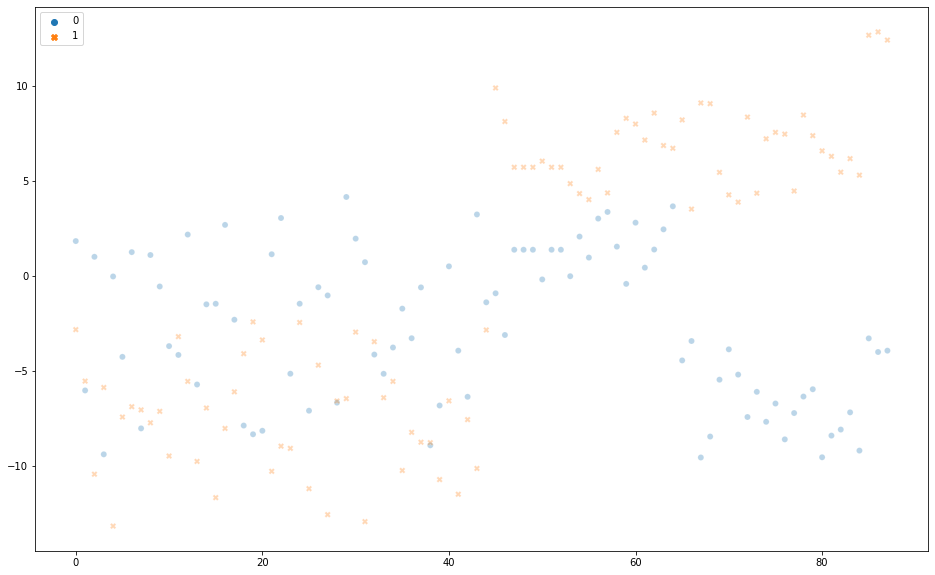

In [25]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

perplexity = 20
learning_rate = 'auto'
fig_path = base_models_path / "CN" / "model" / f"TSNE-discriminative-features-cffn--perplexity-{perplexity}--lr-{learning_rate}.png"

disc_embed = TSNE(n_components=2, learning_rate=learning_rate, perplexity=perplexity).fit_transform(tsne_in)

df = pd.DataFrame()
df["tsne-2d-one"] = disc_embed[:, 0]
df["tsne-2d-two"] = disc_embed[:, 1]

plt.figure(figsize=(16, 10))
sns.scatterplot(
    # hue="y",
    # palette=sns.color_palette("hls", 10),
    data=disc_embed,
    # legend=df,
    alpha=0.3,
)
# scat_plot.savefig(str(fig_path))
plt.savefig(str(fig_path))

In [67]:
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transforms
import os
%matplotlib inline

# grid reconstructed images

seed = 999
rng = np.random.default_rng(seed=seed)
reconstruction_output_path_phase1_cffn_model = base_models_path / "CFFN" / "model" / "reconstruction"
reconstructed_image_paths = [reconstruction_output_path_phase1_cffn_model / path_ for path_ in os.listdir(str(reconstruction_output_path_phase1_cffn_model))]
for reconstructed_image_path in reconstructed_image_paths:
  conv5_path = reconstructed_image_path / "conv5"
  grid_output_path = conv5_path / "grid.png"
  conv5_image_paths = sorted(conv5_path.glob("**/*.png"))
  rng.shuffle(conv5_image_paths)

  transform = transforms.Compose([transforms.ToTensor(), transforms.CenterCrop(128)])
  conv5_images = transform(Image.open(conv5_image_paths[-1]).convert("RGB")).unsqueeze(0)
  for idx, conv5_img_path in enumerate(conv5_image_paths):
    if idx == len(conv5_image_paths) - 1:
      break
    conv5_image = transform(Image.open(conv5_img_path).convert("RGB")).unsqueeze(0)
    conv5_images = torch.concat([conv5_images, conv5_image], dim=0)

  grid_of_imgs = make_grid(conv5_images, padding=2, normalize=True, nrows=16)
  # plt.imshow(grid_of_imgs.permute(1, 2, 0).detach().cpu().numpy())
  save_image(grid_of_imgs, grid_output_path)